In [1]:
import librosa
import tensorflow as tf
import numpy as np
import glob
import os

2025-03-09 04:27:03.669228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 04:27:03.676382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741474623.684859  153984 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741474623.687266  153984 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 04:27:03.696518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Data Preparation

In [2]:
training_real = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/training/real"
training_fake = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/training/fake"
testing_real = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/testing/real"
testing_fake = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/testing/fake"
validation_real = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/validation/real"
validation_fake = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/validation/fake"

max_files_per_category = 2000000

def preprocess_audio(file_path, target_sr=16000, fixed_length=32000):
    """Load, preprocess, and extract Mel spectrogram from an audio file."""
    try:
        audio, sr = librosa.load(file_path, sr=target_sr)
        audio, _ = librosa.effects.trim(audio)  
        
        if len(audio) == 0 or np.max(np.abs(audio)) == 0:
            print(f"Skipping silent file: {file_path}")
            return None
        
        audio = audio / np.max(np.abs(audio))  
        
        if len(audio) < fixed_length:
            audio = np.pad(audio, (0, fixed_length - len(audio)), mode="constant")
        else:
            audio = audio[:fixed_length]
        
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sr, n_mels=128)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        return mel_spectrogram_db.flatten() 
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  

def process_folder(folder_path, label, max_files=None):
    """Process up to `max_files` WAV files in a folder and return (features, label) pairs."""
    file_paths = glob.glob(os.path.join(folder_path, "*.wav"))
    if max_files:
        file_paths = file_paths[:max_files]
    
    data = []
    for file in file_paths:
        features = preprocess_audio(file)
        if features is not None: 
            data.append((features, label))
    
    return data

data = {
    "train": process_folder(training_real, 0, max_files_per_category) + process_folder(training_fake, 1, max_files_per_category),
    "test": process_folder(testing_real, 0, max_files_per_category) + process_folder(testing_fake, 1, max_files_per_category),
    "val": process_folder(validation_real, 0, max_files_per_category) + process_folder(validation_fake, 1, max_files_per_category),
}

Skipping silent file: /media/smayan/F20C9EC00C9E7EF3/cidecode/audio/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav
Skipping silent file: /media/smayan/F20C9EC00C9E7EF3/cidecode/audio/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav


In [3]:
X_train = np.array([features for features, _ in data["train"]])
y_train = np.array([label for _, label in data["train"]])

X_test = np.array([features for features, _ in data["test"]])
y_test = np.array([label for _, label in data["test"]])

X_val = np.array([features for features, _ in data["val"]])
y_val = np.array([label for _, label in data["val"]])

print(f"Train shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test shape: {X_test.shape}, Labels: {y_test.shape}")
print(f"Validation shape: {X_val.shape}, Labels: {y_val.shape}")

Train shape: (57072, 8064), Labels: (57072,)
Test shape: (5722, 8064), Labels: (5722,)
Validation shape: (10798, 8064), Labels: (10798,)


# RFC

In [5]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred_test = rf_classifier.predict(X_test)


NameError: name 'accuracy_score' is not defined

In [7]:
import joblib
joblib.dump(rf_classifier, "rf_classifier.joblib")

['rf_classifier.joblib']

In [8]:
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
y_pred_train = rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
y_pred_val = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Test Accuracy: 0.7272
Train Accuracy: 1.0000
Validation Accuracy: 0.9714


## XGBOOST

In [37]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=8,  
    learning_rate=0.1, 
    random_state=42  
)

xgb_classifier.fit(X_train, y_train)

y_pred_test = xgb_classifier.predict(X_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
y_pred_val = xgb_classifier.predict(X_val)

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_val = xgb_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"XGBOOST Validation Accuracy: {val_accuracy:.4f}")

Train Accuracy: 0.9810
Test Accuracy: 0.7662
XGBOOST Validation Accuracy: 0.9913


In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
y_pred_test = xgb_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_train = xgb_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

test_recall = recall_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")

y_pred_val = xgb_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"XGBOOST Validation Accuracy: {val_accuracy:.4f}")

val_recall = recall_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)
val_conf_matrix = confusion_matrix(y_val, y_pred_val)

print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation Confusion Matrix:\n{val_conf_matrix}")

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred_test))

print("\nClassification Report for Validation Set:")
print(classification_report(y_val, y_pred_val))

Test Accuracy: 0.7662
Train Accuracy: 1.0000
Test Recall: 0.5827
Test Precision: 0.9330
Test F1 Score: 0.7174
Test Confusion Matrix:
[[2686  122]
 [1216 1698]]
XGBOOST Validation Accuracy: 0.9913
Validation Recall: 0.9985
Validation Precision: 0.9843
Validation F1 Score: 0.9914
Validation Confusion Matrix:
[[5314   86]
 [   8 5390]]

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      2808
           1       0.93      0.58      0.72      2914

    accuracy                           0.77      5722
   macro avg       0.81      0.77      0.76      5722
weighted avg       0.81      0.77      0.76      5722


Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5400
           1       0.98      1.00      0.99      5398

    accuracy                           0.99     10798
   macro avg       0.99      0.99      0

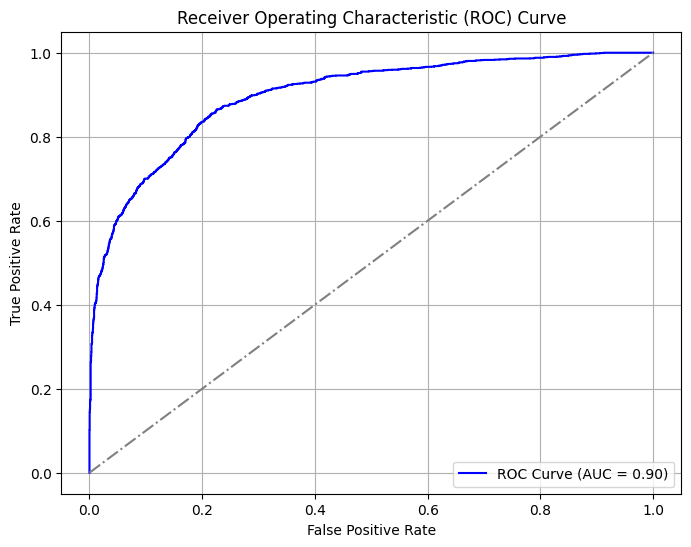

AUC (Area Under the Curve) for Logistic Regression: 0.898152


In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_prob_test_xgb = xgb_classifier.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_prob_test_xgb)
roc_auc = roc_auc_score(y_test, y_prob_test_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='-.')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

 
print(f"AUC (Area Under the Curve) for Logistic Regression: {roc_auc:.6f}")

## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)
y_pred_test_lr = log_reg_model.predict(X_test)
test_accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
print(f"Logistic Regression Test Accuracy: {test_accuracy_lr:.4f}")



Logistic Regression Test Accuracy: 0.7863


/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
import joblib
model_filename = 'logistic_regression_model.joblib'
joblib.dump(log_reg_model, model_filename)

['logistic_regression_model.joblib']

In [13]:
y_pred_test_lr = log_reg_model.predict(X_test)

test_accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
print(f"Logistic Regression Test Accuracy: {test_accuracy_lr:.4f}")

y_pred_train = log_reg_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

test_recall_lr = recall_score(y_test, y_pred_test_lr)
test_precision_lr = precision_score(y_test, y_pred_test_lr)
test_f1_lr = f1_score(y_test, y_pred_test_lr)
test_conf_matrix_lr = confusion_matrix(y_test, y_pred_test_lr)

print(f"Test Recall: {test_recall_lr:.4f}")
print(f"Test Precision: {test_precision_lr:.4f}")
print(f"Test F1 Score: {test_f1_lr:.4f}")
print(f"Test Confusion Matrix:\n{test_conf_matrix_lr}")

y_pred_val_lr = log_reg_model.predict(X_val)
val_accuracy_lr = accuracy_score(y_val, y_pred_val_lr)
print(f"Logistic Regression Validation Accuracy: {val_accuracy_lr:.4f}")

val_recall_lr = recall_score(y_val, y_pred_val_lr)
val_precision_lr = precision_score(y_val, y_pred_val_lr)
val_f1_lr = f1_score(y_val, y_pred_val_lr)
val_conf_matrix_lr = confusion_matrix(y_val, y_pred_val_lr)

print(f"Validation Recall: {val_recall_lr:.4f}")
print(f"Validation Precision: {val_precision_lr:.4f}")
print(f"Validation F1 Score: {val_f1_lr:.4f}")
print(f"Validation Confusion Matrix:\n{val_conf_matrix_lr}")

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred_test_lr))

print("\nClassification Report for Validation Set:")
print(classification_report(y_val, y_pred_val_lr))


Logistic Regression Test Accuracy: 0.7863
Train Accuracy: 0.9810
Test Recall: 0.5988
Test Precision: 0.9700
Test F1 Score: 0.7405
Test Confusion Matrix:
[[2754   54]
 [1169 1745]]
Logistic Regression Validation Accuracy: 0.9499
Validation Recall: 0.9663
Validation Precision: 0.9356
Validation F1 Score: 0.9507
Validation Confusion Matrix:
[[5041  359]
 [ 182 5216]]

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82      2808
           1       0.97      0.60      0.74      2914

    accuracy                           0.79      5722
   macro avg       0.84      0.79      0.78      5722
weighted avg       0.84      0.79      0.78      5722


Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5400
           1       0.94      0.97      0.95      5398

    accuracy                           0.95     10798
   macro

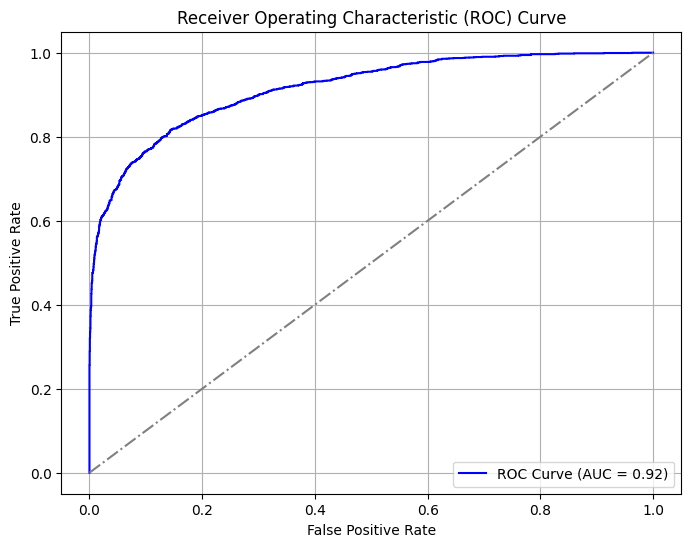

AUC (Area Under the Curve) for Logistic Regression: 0.915134


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_prob_test_lr = log_reg_model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_prob_test_lr)
roc_auc = roc_auc_score(y_test, y_prob_test_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='-.')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

 
print(f"AUC (Area Under the Curve) for Logistic Regression: {roc_auc:.6f}")

## Testing the model on New Audio Files

In [44]:
def predict_on_audio(model, audio_path):
    features = preprocess_audio(audio_path)
    if features is None:
        return "Error: Could not process the audio file."
    
    prediction = model.predict([features])
    return "Fake" if prediction == 1 else "Real"


audio_file = input("Enter the path of the audio file to predict (e.g., /path/to/audio.wav): ")

print(f"Prediction using Logistic Regression: {predict_on_audio(log_reg_model, audio_file)}")

print(f"Prediction using XGBOOST: {predict_on_audio(xgb_classifier, audio_file)}")

Prediction using Logistic Regression: Fake
Prediction using XGBOOST: Real


## Having a Comparison Validation with a larger validation set for both models

In [25]:
import os
import glob
import pandas as pd

folder_path = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/validation/real"

file_paths = glob.glob(os.path.join(folder_path, "*.wav"))

# Create a DataFrame
df = pd.DataFrame({"file_name": file_paths, "label": 0})

# Display the first few rows
df.head()



,file_name,label
0,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,0
1,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,0
2,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,0
3,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,0
4,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,0


In [26]:
import os
import glob
import pandas as pd

folder_path = "/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/validation/fake"

file_paths = glob.glob(os.path.join(folder_path, "*.wav"))

df2 = pd.DataFrame({"file_name": file_paths, "label": 1})

df2.head()



,file_name,label
0,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1
1,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1
2,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1
3,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1
4,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1


In [27]:
df3 = pd.concat([df, df2], ignore_index=True)

In [28]:
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

In [41]:
df3.head()

,file_name,label
0,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,0
1,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,0
2,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1
3,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1
4,/media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...,1


In [39]:
results = []

for _, row in df.iterrows():
    file_path = row["file_name"]
    true_label = "Real" if row["label"] == 0 else "Fake"
    
    pred_lr = predict_on_audio(log_reg_model, file_path)
    pred_xgb = predict_on_audio(xgb_classifier, file_path)
    
    results.append({
        "file_name": file_path,
        "true_label": true_label,
        "pred_lr": pred_lr,
        "pred_xgb": pred_xgb
    })

results_df = pd.DataFrame(results)

print(results_df.head())

results_df.to_csv("prediction_results.csv", index=False)

accuracy_lr = (results_df["true_label"] == results_df["pred_lr"]).mean()
accuracy_xgb = (results_df["true_label"] == results_df["pred_xgb"]).mean()

print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.4f}%")
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.6f}%")

                                           file_name true_label pred_lr  \
0  /media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...       Real    Fake   
1  /media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...       Real    Real   
2  /media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...       Real    Real   
3  /media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...       Real    Real   
4  /media/smayan/F20C9EC00C9E7EF3/cidecode/audio/...       Real    Real   

  pred_xgb  
0     Real  
1     Real  
2     Real  
3     Real  
4     Real  
Logistic Regression Accuracy: 93.3519%
XGBoost Accuracy: 98.41%


In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_train)


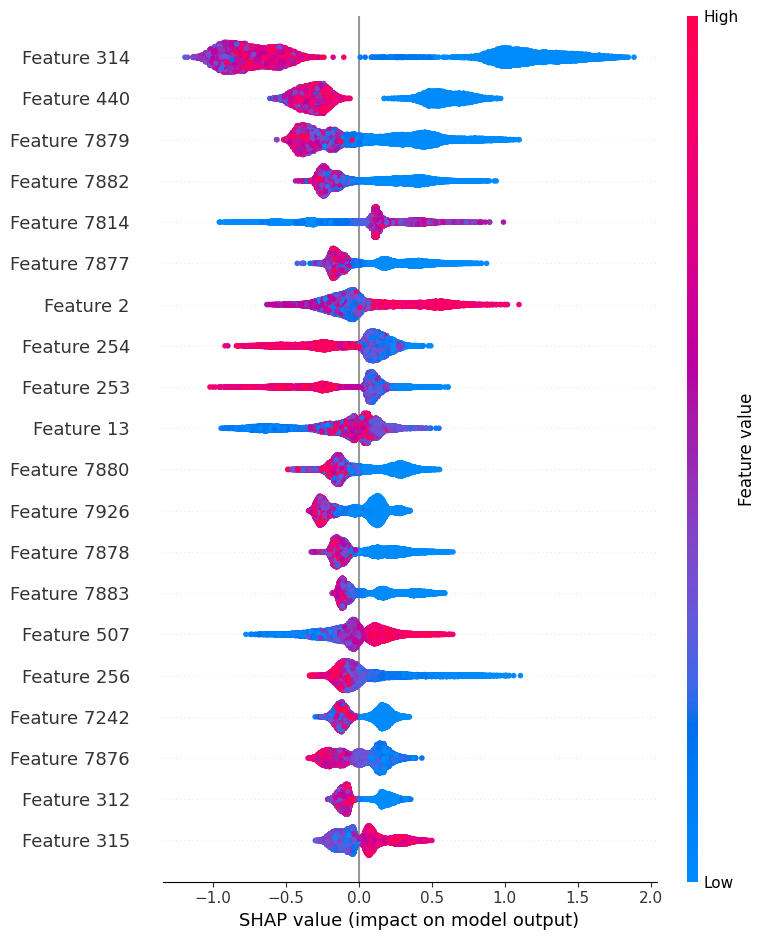

In [ ]:
shap.summary_plot(shap_values, X_train)
